In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import numba
import numba.typed

from pathlib import Path
from tqdm import trange, tqdm
import sys
import seaborn as sns
import scipy.stats
import os
import pysam
import pprint
import pickle
import joblib
import polars as pl

# This is needed before pybedtools to make sure bedtools is imported on sanger JupyterHub 
os.environ["PATH"] += ":" + os.path.join(sys.prefix, "bin")
import pybedtools

pd.set_option('display.max_rows', 1000)


In [3]:
sys.path.append(str(Path(os.getcwd()).parent))
from src import liftover, annotate, diagnostics, inference

In [4]:
aut_chrom_names = [f"chr{i}" for i in list(range(1, 23))]
chrom_names = aut_chrom_names + ["chrX", "chrY"]

# Read the classified events

In [5]:
# Samples to do
sample_ids = [
    "PD50477f",
    # "PD50508bf", -- ignore; merged two sampling dates just for phasing, but should be analyzed separately
    "PD50519d",
    # "PD47269d", -- don't use, not there
    "PD50508f",
    # "PD50511e", -- don't use, likely mixture
    "PD50523b",
    # "PD48473b", -- don't use, not there
    "PD50521b",
    "PD50508b",
    # "PD50521be", -- ignore; merged two sampling dates just for phasing, but should be analyzed separately
    "PD46180c",
    # "PD50502f", -- don't use, likely mixture
    "PD50521e",
    # "PD50511e_SS",  --- don't use
    "PD50489e",
]

cls_df = pl.concat([
    pl.read_parquet(
        str(Path("/lustre/scratch126/casm/team154pc/sl17/03.sperm/02.results/01.read_alignment/01.ccs/04.hifiasm/02.hifiasm_0.19.5-r592/02.chromosome_length_scaffolds")
            / f"{focal_sample_id}" / "reads" / f"{chrom}_RagTag.certainty_0.95.classified_reads.parquet")
    ) \
    for focal_sample_id in sample_ids
    for chrom in aut_chrom_names
])

In [6]:
trusty_cls_df = (cls_df
    .filter(~pl.col("has_common_transition"))
    .filter(pl.col("min_coverage_between_transitions_hap1") >= 3)
    .filter(pl.col("min_coverage_between_transitions_hap2") >= 3)
)

# Utils

In [7]:
def hist_transitions(df, upto=2):
    return np.histogram(df["n_transitions"], bins=np.arange(upto+2), density=True)[0]

# Functions to get call set for a single sample

In [30]:
def generate_call_set(focal_sample_ids, take_every=1, bootstrap=False, cutoff=None, min_snps=0):
    certainty = "0.95"
    
    # Get all the other reads
    all_sampled_reads = []

    for focal_sample_id in focal_sample_ids:
        for t2t_chrom in aut_chrom_names:
            denovo_chrom = t2t_chrom + "_RagTag"

            patterns_filename = Path("/lustre/scratch126/casm/team154pc/sl17/03.sperm/02.results/01.read_alignment/01.ccs/04.hifiasm/02.hifiasm_0.19.5-r592/02.chromosome_length_scaffolds/") \
                / f"{focal_sample_id}" / "reads" / f"{denovo_chrom}.certainty_{certainty}.candidate_reads.patterns.parquet"

            pat_df = pl.scan_parquet(patterns_filename)
            pat_df = pat_df.gather_every(take_every)

            all_sampled_reads.append(pat_df)

    all_sampled_reads = pl.concat(all_sampled_reads).collect(streaming=True)
    
    # Create the joint dataframe
    both_df = (
        pl.concat([
            (trusty_cls_df
                .filter(pl.col("class") != "CNCO")
                .filter(pl.col("sample_id").is_in(focal_sample_ids))
                .select(["read_length", "snp_positions_on_read", "idx_transitions", "sample_id", "read_name"])
                .with_columns(weight = 1)
            ), 
            (all_sampled_reads
                .select(["read_length", "snp_positions_on_read", "idx_transitions", "sample_id", "read_name"])
                .with_columns(weight = take_every)
            )
        ])
    )   
    
    # Make sure we have minimal number of SNPs
    both_df = both_df.filter(pl.col("snp_positions_on_read").list.len() >= min_snps)
    
    # Cutoff if needed
    if cutoff:
        both_df = both_df.filter(
            pl.when(pl.col("idx_transitions").list.len() != 2).then(pl.lit(True)).otherwise(
                (pl.col("snp_positions_on_read").list.get(pl.col("idx_transitions").list.get(1)+1) - \
                 pl.col("snp_positions_on_read").list.get(pl.col("idx_transitions").list.get(0))) < cutoff
            )
        )
    
    # Bootstrap if needed
    if bootstrap:
        both_df = both_df.sample(n = len(both_df), with_replacement = True)
    
    # Add useful fields
    aug_both_df = (both_df
        .with_columns(
            prob_inside = 1 - (pl.col("snp_positions_on_read").list.get(0) + pl.col("read_length") - pl.col("snp_positions_on_read").list.get(-1)) / pl.col("read_length"),
            n_transitions = pl.col("idx_transitions").list.len(),
        )
        .with_columns(
            rounded_prob_inside = pl.col("prob_inside") // 0.1 * 0.1,
        )
    )
    
    return aug_both_df


In [31]:
def inferme(
    focal_sample_ids, 
    take_every=100, 
    bootstrap=False, 
    recombination_rate_per_bp_range=[1e-7, 1e-7],
    cutoff=None,
    min_snps=0,
):
    df = generate_call_set(focal_sample_ids, take_every, bootstrap, cutoff, min_snps)

    res = inference.maximum_likelihood_all_reads(
        df["read_length"].to_numpy(),
        df["snp_positions_on_read"].to_numpy(),
        df["idx_transitions"].to_numpy(),
        df["weight"].to_numpy(),
        [0, 1],
        [1, 10000],
        recombination_rate_per_bp_range,
    )
    
    return res

# Estimate per sample

In [21]:
%%time
allres = joblib.Parallel(n_jobs=-1, verbose=10)(
    joblib.delayed(inferme)([focal_sample_id]) for focal_sample_id in sample_ids
)

allres = dict(zip(sample_ids, allres))

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   9 | elapsed:   16.2s remaining:   56.8s
[Parallel(n_jobs=-1)]: Done   3 out of   9 | elapsed:   16.2s remaining:   32.5s
[Parallel(n_jobs=-1)]: Done   4 out of   9 | elapsed:   16.9s remaining:   21.1s
[Parallel(n_jobs=-1)]: Done   5 out of   9 | elapsed:   17.5s remaining:   14.0s
[Parallel(n_jobs=-1)]: Done   6 out of   9 | elapsed:   17.9s remaining:    8.9s
[Parallel(n_jobs=-1)]: Done   7 out of   9 | elapsed:   18.6s remaining:    5.3s


CPU times: user 67.9 ms, sys: 378 ms, total: 445 ms
Wall time: 20.5 s


[Parallel(n_jobs=-1)]: Done   9 out of   9 | elapsed:   20.5s finished


In [22]:
for k,v in allres.items():
    print(k,'\t',v.x[0],'\t',v.x[1])

PD50477f 	 0.1348519917092187 	 26.614301150504446
PD50519d 	 0.11012866937978177 	 73.18830467556457
PD50508f 	 0.10183691287894149 	 22.845820041533912
PD50523b 	 0.11326284777317752 	 60.322522576934546
PD50521b 	 0.12199967357498825 	 70.47911316292749
PD50508b 	 0.10923975103614439 	 25.185702291095694
PD46180c 	 0.12836521150089641 	 61.71694646507646
PD50521e 	 0.12997952603822954 	 73.53056039717899
PD50489e 	 0.11806953281700366 	 44.06864819912904


# Estimate for all together

In [30]:
%%time
together_res = inferme(sample_ids, 100, False)

print(together_res.x)

[1.19543415e-01 5.71166317e+01 1.00000000e-07]
CPU times: user 1min 18s, sys: 4.59 s, total: 1min 23s
Wall time: 46.8 s


# Bootstrap estimator for all together

In [31]:
%%time
allboots = joblib.Parallel(n_jobs=-1, verbose=10)(
    joblib.delayed(inferme)(sample_ids, 100, True) for i in range(50)
)


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:  1.8min
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:  3.4min
/nfs/treeoflife-01/teams/tola/users/rs42/miniconda3/envs/sperm/lib/python3.11/site-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(
[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed:  3.8min
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:  6.7min
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:  8.4min
[Parallel(n_jobs=-1)]: Done  41 out of  50 | elapsed:  9.8min remaining:  2.1min
[Parallel(n_jobs=-1)]: Done  47 out of  50 | elapsed: 11.1min remaining:   42.4s


CPU times: user 1.33 s, sys: 1.32 s, total: 2.65 s
Wall time: 11min 10s


[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed: 11.2min finished


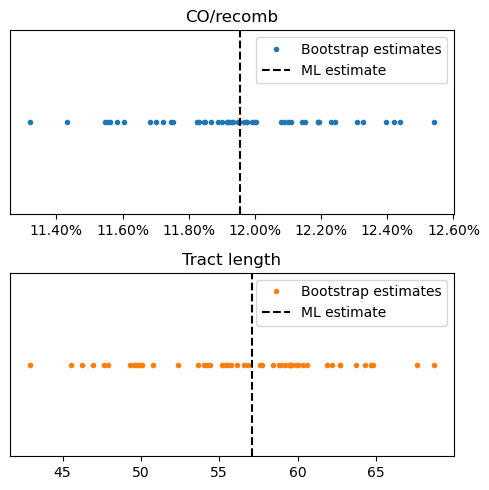

In [62]:
fig, axs = plt.subplots(2, 1, figsize=(5,5))

axs[0].plot(
    [b.x[0] for b in allboots],
    np.zeros(len(allboots)),
    '.',
    label="Bootstrap estimates",
)
axs[0].axvline(together_res.x[0], color="black", ls='--', label="ML estimate");
axs[0].xaxis.set_major_formatter(ticker.PercentFormatter(1, 2));
axs[0].set_title("CO/recomb");
axs[0].set_yticks([]);
axs[0].legend();

axs[1].plot(
    [b.x[1] for b in allboots],
    np.zeros(len(allboots)),
    '.',
    label="Bootstrap estimates",
    color='C1',
)
axs[1].axvline(together_res.x[1], color="black", ls='--', label="ML estimate");
axs[1].set_title("Tract length");
axs[1].set_yticks([]);
axs[1].legend();

fig.tight_layout()
plt.subplots_adjust()

In [79]:
%%time
allboots_one_sample = joblib.Parallel(n_jobs=-1, verbose=10)(
    joblib.delayed(inferme)([sample_ids[0]], 100, True) for i in range(50)
)


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:   19.7s
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:   31.3s
[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed:   36.5s
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:   53.9s
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:  1.1min
[Parallel(n_jobs=-1)]: Done  41 out of  50 | elapsed:  1.3min remaining:   16.7s
[Parallel(n_jobs=-1)]: Done  47 out of  50 | elapsed:  1.4min remaining:    5.3s


CPU times: user 328 ms, sys: 442 ms, total: 770 ms
Wall time: 1min 24s


[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:  1.4min finished


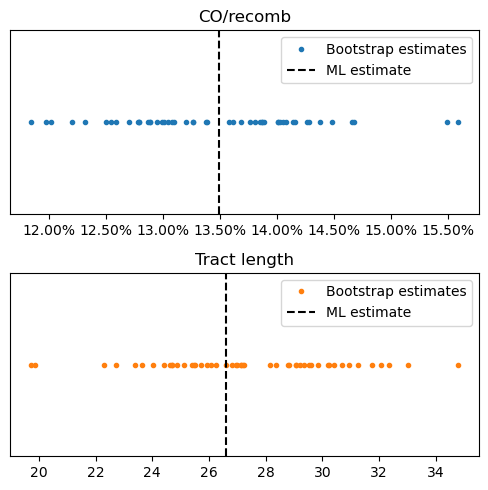

In [80]:
fig, axs = plt.subplots(2, 1, figsize=(5,5))

axs[0].plot(
    [b.x[0] for b in allboots_one_sample],
    np.zeros(len(allboots_one_sample)),
    '.',
    label="Bootstrap estimates",
)
axs[0].axvline(allres[sample_ids[0]].x[0], color="black", ls='--', label="ML estimate");
axs[0].xaxis.set_major_formatter(ticker.PercentFormatter(1, 2));
axs[0].set_title("CO/recomb");
axs[0].set_yticks([]);
axs[0].legend();

axs[1].plot(
    [b.x[1] for b in allboots_one_sample],
    np.zeros(len(allboots_one_sample)),
    '.',
    label="Bootstrap estimates",
    color='C1',
)
axs[1].axvline(allres[sample_ids[0]].x[1], color="black", ls='--', label="ML estimate");
axs[1].set_title("Tract length");
axs[1].set_yticks([]);
axs[1].legend();

fig.tight_layout()
plt.subplots_adjust()

# Estimate for all together, fitting also recombination rate

In [64]:
%%time
together_res_with_rate = inferme(sample_ids, 100, False, [1e-9, 1e-6])

print(together_res_with_rate.x)

[4.21778904e-01 1.82318572e+02 2.82997492e-08]
CPU times: user 1min 37s, sys: 4.65 s, total: 1min 41s
Wall time: 1min 4s


In [77]:
%%time
allres_with_rate = joblib.Parallel(n_jobs=-1, verbose=10)(
    joblib.delayed(inferme)([focal_sample_id], 100, False, [1e-9, 1e-6]) for focal_sample_id in sample_ids
)

allres_with_rate = dict(zip(sample_ids, allres_with_rate))

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   9 | elapsed:   13.3s remaining:   46.5s
[Parallel(n_jobs=-1)]: Done   3 out of   9 | elapsed:   14.3s remaining:   28.7s
[Parallel(n_jobs=-1)]: Done   4 out of   9 | elapsed:   16.8s remaining:   21.0s
[Parallel(n_jobs=-1)]: Done   5 out of   9 | elapsed:   17.4s remaining:   13.9s
[Parallel(n_jobs=-1)]: Done   6 out of   9 | elapsed:   17.4s remaining:    8.7s
[Parallel(n_jobs=-1)]: Done   7 out of   9 | elapsed:   18.2s remaining:    5.2s


CPU times: user 69.9 ms, sys: 13.2 ms, total: 83.1 ms
Wall time: 24.2 s


[Parallel(n_jobs=-1)]: Done   9 out of   9 | elapsed:   24.2s finished


In [78]:
for k,v in allres_with_rate.items():
    print(f"{k}\t{v.x[0]*100:2.3f}\t{v.x[1]:.2f}\t{v.x[2]:1.3e}")

PD50477f	1.362	2.92	1.000e-06
PD50519d	34.348	196.72	3.201e-08
PD50508f	16.246	37.53	6.263e-08
PD50523b	34.945	168.27	3.227e-08
PD50521b	47.113	242.18	2.566e-08
PD50508b	16.080	36.82	6.795e-08
PD46180c	57.341	269.19	2.221e-08
PD50521e	50.716	259.66	2.555e-08
PD50489e	39.120	141.52	3.041e-08


# Estimate all samples jointly, 5% longest cutoff 

In [18]:
%%time

# 6700 is the 5% quantile for outer difference for called GCs

allres_cutoff = joblib.Parallel(n_jobs=-1, verbose=10)(
    joblib.delayed(inferme)(
        [focal_sample_id],
        100, 
        False, 
        [1e-7, 1e-7],
        6700,
    ) for focal_sample_id in sample_ids
)

allres_cutoff = dict(zip(sample_ids, allres_cutoff))

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   9 | elapsed:   14.8s remaining:   51.9s
[Parallel(n_jobs=-1)]: Done   3 out of   9 | elapsed:   16.5s remaining:   32.9s
[Parallel(n_jobs=-1)]: Done   4 out of   9 | elapsed:   18.6s remaining:   23.3s
[Parallel(n_jobs=-1)]: Done   5 out of   9 | elapsed:   19.0s remaining:   15.2s
[Parallel(n_jobs=-1)]: Done   6 out of   9 | elapsed:   19.3s remaining:    9.7s
[Parallel(n_jobs=-1)]: Done   7 out of   9 | elapsed:   20.2s remaining:    5.8s


CPU times: user 59.3 ms, sys: 70.2 ms, total: 130 ms
Wall time: 23.4 s


[Parallel(n_jobs=-1)]: Done   9 out of   9 | elapsed:   23.4s finished


In [23]:
for k,v in allres_cutoff.items():
    print(k,'\t',v.x[0],'\t',v.x[1],'\t Prev:', allres[k].x[1])

PD50477f 	 0.13506919994779806 	 25.752676856793762 	 Prev: 26.614301150504446
PD50519d 	 0.11021813593251487 	 72.88368107862314 	 Prev: 73.18830467556457
PD50508f 	 0.10266801259048916 	 17.1779198118035 	 Prev: 22.845820041533912
PD50523b 	 0.11348439686810774 	 56.338714781293504 	 Prev: 60.322522576934546
PD50521b 	 0.1226716948567243 	 44.59593765585154 	 Prev: 70.47911316292749
PD50508b 	 0.10934718868922835 	 24.74005922413786 	 Prev: 25.185702291095694
PD46180c 	 0.1285939615062887 	 60.77515617590427 	 Prev: 61.71694646507646
PD50521e 	 0.13031586149114052 	 71.31915029252833 	 Prev: 73.53056039717899
PD50489e 	 0.1216847427575648 	 24.54033035630964 	 Prev: 44.06864819912904


# Estimate all samples, 5% longest cutoff 

In [20]:
%%time
together_res_cutoff = inferme(sample_ids, 100, False, [1e-7, 1e-7], 6700)

print(together_res_cutoff.x)

[1.20003413e-01 5.05538807e+01 1.00000000e-07]
CPU times: user 1min 15s, sys: 4.01 s, total: 1min 19s
Wall time: 47.1 s


In [28]:
%%time
together_res_cutoff2 = inferme(sample_ids, 100, False, [1e-7, 1e-7], 1000)

print(together_res_cutoff2.x)

[1.25679106e-01 1.08385088e+01 1.00000000e-07]
CPU times: user 1min 9s, sys: 4.21 s, total: 1min 14s
Wall time: 42.1 s


# Estimate all samples, SNP count cutoff

In [33]:
%%time

allres_min_snps = joblib.Parallel(n_jobs=-1, verbose=10)(
    joblib.delayed(inferme)(
        sample_ids,
        100, 
        False, 
        [1e-7, 1e-7],
        None,
        min_snps
    ) for min_snps in range(1, 10)
)


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   9 | elapsed:  1.4min remaining:  4.9min
[Parallel(n_jobs=-1)]: Done   3 out of   9 | elapsed:  1.4min remaining:  2.8min
[Parallel(n_jobs=-1)]: Done   4 out of   9 | elapsed:  1.4min remaining:  1.8min
[Parallel(n_jobs=-1)]: Done   5 out of   9 | elapsed:  1.5min remaining:  1.2min
[Parallel(n_jobs=-1)]: Done   6 out of   9 | elapsed:  1.5min remaining:   45.7s
[Parallel(n_jobs=-1)]: Done   7 out of   9 | elapsed:  1.6min remaining:   26.8s


CPU times: user 172 ms, sys: 463 ms, total: 636 ms
Wall time: 1min 55s


[Parallel(n_jobs=-1)]: Done   9 out of   9 | elapsed:  1.9min finished


In [34]:
for i,v in enumerate(allres_min_snps):
    print(i+1,'\t',v.x[0],'\t',v.x[1])

1 	 0.11954341503264315 	 57.116631693069934
2 	 0.11911164667278168 	 58.883358302222675
3 	 0.11218984774601828 	 58.58330636088596
4 	 0.10939097507150465 	 58.30492722560661
5 	 0.10723215177941392 	 53.956019382774386
6 	 0.10567683999952107 	 52.328334611690096
7 	 0.1034817574889488 	 44.44883147230537
8 	 0.1020188910267217 	 40.90021729929994
9 	 0.1023484694013948 	 38.37143709977052
